Double Digit Classification using Deep Neural Network

Importing necessary packages

In [145]:
import matplotlib
import torch, torchvision
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random 
import torch.nn.functional as F
from matplotlib import transforms as ts
from PIL import Image

from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image

%matplotlib inline

# Setting the PseudoRandom Generator Seeds for better reproducibility

torch.manual_seed(99)
random.seed(99)
np.random.seed(99)

# this 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
input_size  = 28*56   # images are 28x56 pixels
output_size = 100      # there are 100 classes
classNames = list(range(100))

Loading MNIST Dataset

In [71]:
mnist_full_train = torchvision.datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_set, val_set = torch.utils.data.random_split(mnist_full_train, [50000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=10, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=10, shuffle=True)

Checking the dimensions

In [72]:
for batch_idx, (data, target) in enumerate(train_loader):
    data1 = torch.squeeze(data, 1)
    if batch_idx == 7:
        print(data.size(),target.size())
        break

torch.Size([10, 1, 28, 28]) torch.Size([10])


Function to create two digit data

In [73]:
def double(data_single, target_single):
        data_list = []
        target_list = []
        for i in range(10):
            for j in range(10):
                data_list.append((torch.cat((data_single[i], data_single[j]), 2)))
                target_list.append(torch.tensor(int(target_single[i])*10 + int(target_single[j])))
        #data_tensor = torch.tensor(data_list)
        return (data_list, target_list)

Displaying 1 batch of double digit images

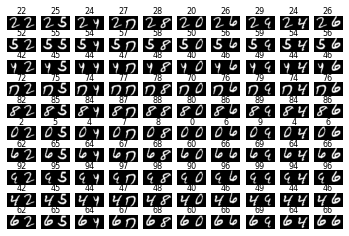

In [147]:
for ix, (img, lbl) in enumerate(train_loader):
    img_list, lbl_list = double(img, lbl)
    break
image = torch.stack(img_list)
label = torch.stack(lbl_list)

def visualize(image, label, num): 
    total = num
    if np.sqrt(num) != int(np.sqrt(num)):
        col = int(np.sqrt(num)) + 1 
    else:
        col = int(np.sqrt(num))
    rows = total // col
    if total % col != 0:
        rows += 1

    fig = plt.figure(1)
    for k in range(total):
        ax = fig.add_subplot(rows,col,k+1)
        ax.set_title(label[k].item(), size=8, pad=0)
        ax.axis('off')
        ax.imshow(image[k][0,:], cmap = 'gray')

    # plt.subplots_adjust(left=0.1, bottom=0.1, right=0.5, top=0.9, wspace=0.6, hspace=0.3)
    plt.show()

visualize(image, label, 100)

Creating the train, validation and test functions

In [95]:
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np


def train_val(epoch, model):
    N_tot = 0
    N_tot_val = 0
    train_loss = 0
    correct = 0
    val_loss = 0
    correct_val = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data_new, target_new = double(data, target)
        
        data_tensor = torch.stack(data_new)
        target_tensor = torch.stack(target_new)
        data_tensor, target_tensor = data_tensor.to(device), target_tensor.to(device)
        
        optimizer.zero_grad()
        output = model(data_tensor)
        loss = F.nll_loss(output, target_tensor)
        loss.backward()
        optimizer.step()
        N_tot += output.size(0)
        
        train_loss += F.nll_loss(output, target_tensor, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target_tensor.data.view_as(pred)).cpu().sum().item()
   
    print('| Train_Loss: {:.4f}\tTrain_Accuracy: {:.4f}'.format(train_loss / N_tot, correct / N_tot))
    
    model.eval()
    for data, target in val_loader:
        # send to device
        data_new, target_new = double(data, target)
        
        data_tensor = torch.stack(data_new)
        target_tensor = torch.stack(target_new)
        data_tensor, target_tensor = data_tensor.to(device), target_tensor.to(device)
        
        output = model(data_tensor)
        val_loss += F.nll_loss(output, target_tensor, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct_val += pred.eq(target_tensor.data.view_as(pred)).cpu().sum().item()
        N_tot_val += output.size(0)
        
    print('| Validation_Loss: {:.4f}\tValidation_Accuracy: {:.4f}'.format(val_loss / N_tot_val, correct_val / N_tot_val))
    print('\n')
    
    return train_loss / N_tot, correct / N_tot, val_loss / N_tot_val, correct_val / N_tot_val
    
def test(model):
    test_loss = 0
    correct = 0
    N_tot = 0
    model.eval()
    for data, target in test_loader:
        # send to device
        data_new, target_new = double(data, target)
        
        data_tensor = torch.stack(data_new)
        target_tensor = torch.stack(target_new)
        data_tensor, target_tensor = data_tensor.to(device), target_tensor.to(device)
        
        output = model(data_tensor)
        test_loss += F.nll_loss(output, target_tensor, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target_tensor.data.view_as(pred)).cpu().sum().item()
        N_tot += output.size(0)
                
    print('| Test_Loss: {:.4f}\tTest_Accuracy: {:.4f}'.format(test_loss / N_tot, correct / N_tot))
    print('\n')
    
    return test_loss / N_tot, correct / N_tot

Fully Connected Network

In [ ]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, 500), 
            nn.ReLU(), 
            nn.Linear(500,250),
            nn.ReLU(),
            nn.Linear(250,200), 
            nn.ReLU(), 
            nn.Linear(200, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = torch.stack(tuple(x))
        x = x.view(-1, self.input_size)
        return self.network(x)

Train the Network

In [167]:
print("Training on: ", device)
model_fnn = FC2Layer(input_size, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.001, momentum=0.9)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

epoch_length = 50
epoch = list(range(epoch_length))
train_loss = list(range(epoch_length))
train_accuracy = list(range(epoch_length))
val_loss = list(range(epoch_length))
val_accuracy = list(range(epoch_length))

for i in range(epoch_length):
    #epoch[i] = i + 1
    print('| Epoch No.: {:.0f}'.format(i + 1))
    print('\n')
    
    train_loss[i], train_accuracy[i], val_loss[i], val_accuracy[i] = train_val(i, model_fnn)
    


Training on:  cpu
Number of parameters: 980050
| Epoch No.: 1


| Train_Loss: 1.7763	Train_Accuracy: 0.5674
| Validation_Loss: 0.7367	Validation_Accuracy: 0.7992


| Epoch No.: 2


| Train_Loss: 0.5860	Train_Accuracy: 0.8355
| Validation_Loss: 0.4886	Validation_Accuracy: 0.8644


| Epoch No.: 3


| Train_Loss: 0.3860	Train_Accuracy: 0.8896
| Validation_Loss: 0.3656	Validation_Accuracy: 0.8979


| Epoch No.: 4


| Train_Loss: 0.2820	Train_Accuracy: 0.9176
| Validation_Loss: 0.2935	Validation_Accuracy: 0.9184


| Epoch No.: 5


| Train_Loss: 0.2193	Train_Accuracy: 0.9357
| Validation_Loss: 0.2810	Validation_Accuracy: 0.9193


| Epoch No.: 6


| Train_Loss: 0.1811	Train_Accuracy: 0.9467
| Validation_Loss: 0.2216	Validation_Accuracy: 0.9361


| Epoch No.: 7


| Train_Loss: 0.1496	Train_Accuracy: 0.9550
| Validation_Loss: 0.2060	Validation_Accuracy: 0.9400


| Epoch No.: 8


| Train_Loss: 0.1291	Train_Accuracy: 0.9609
| Validation_Loss: 0.2201	Validation_Accuracy: 0.9382


| Epoch No.: 9




In [168]:
test_loss, test_accuracy = test(model_fnn)

| Test_Loss: 0.2101	Test_Accuracy: 0.9630




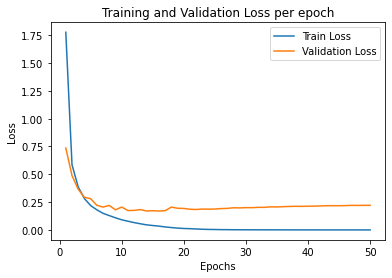

In [169]:
epoch = list(range(1,epoch_length + 1))
plt.plot(epoch, train_loss[:epoch_length], label='Train Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

Some predictions of the test network

In [170]:
def imshow(img, plot):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()   # convert from tensor
    plot.imshow(np.transpose(npimg, (1, 2, 0))) 

In [171]:
def visualize_pred(img, pred_prob, real_label):
    ''' Function for viewing an image and it's predicted classes.
    '''
    #pred_prob = pred_prob.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    #ax1.imshow(img.numpy().squeeze())
    imshow(img, ax1)
    ax1.axis('off')
    pred_label = np.argmax(pred_prob)
    ax1.set_title([classNames[real_label], classNames[pred_label]])
    
    #base = pyplot.gca().transData
    #rot = ts.Affine2D().rotate_deg(90)
    ax2.barh(np.arange(100), pred_prob)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(100))
    ax2.set_yticklabels(np.arange(100))
    ax2.set_title('Prediction Probability')
    ax2.set_xlim(0, 1.1)
    
    plt.tight_layout()
    

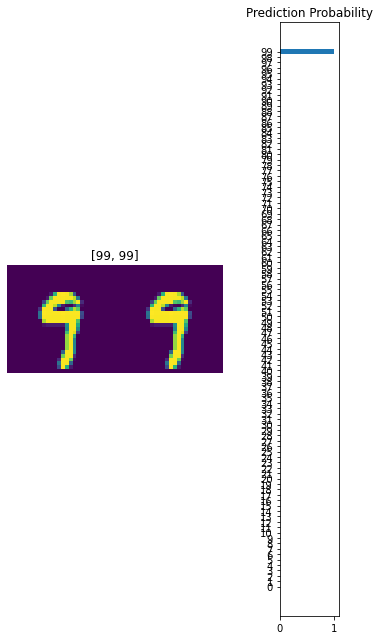

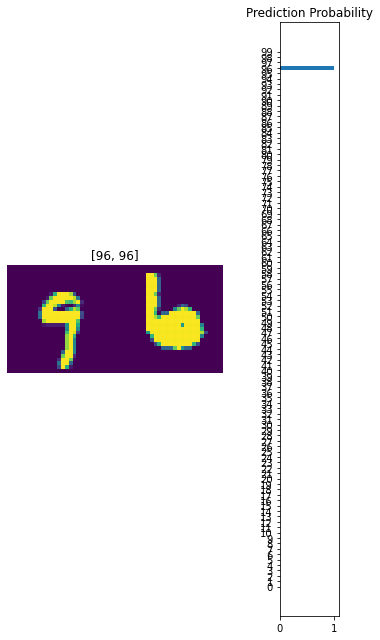

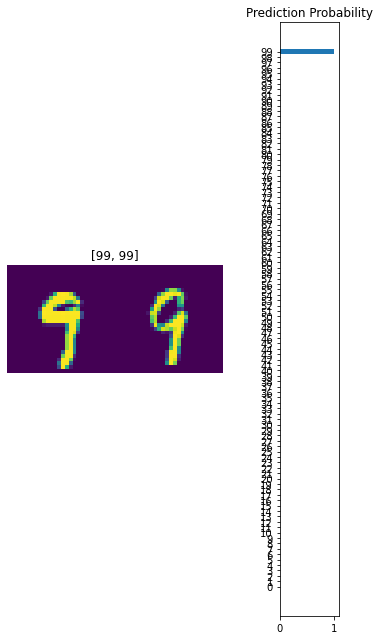

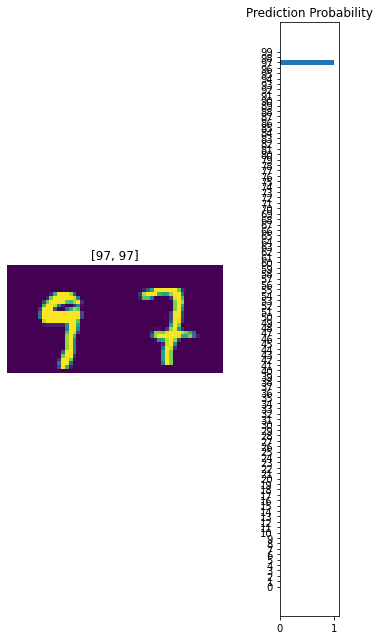

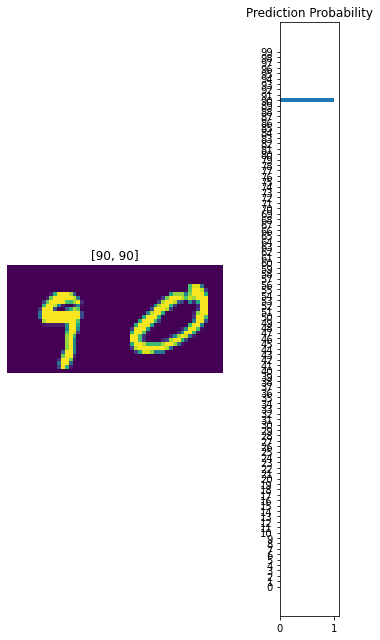

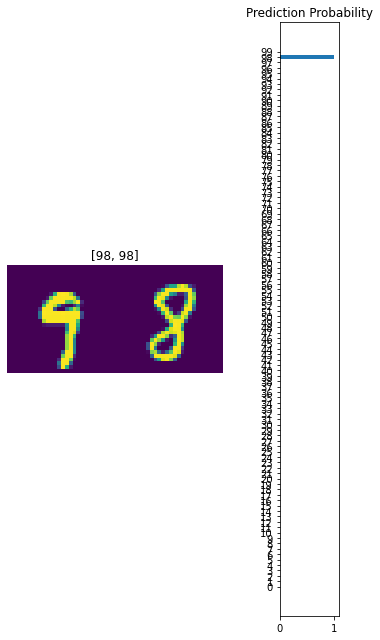

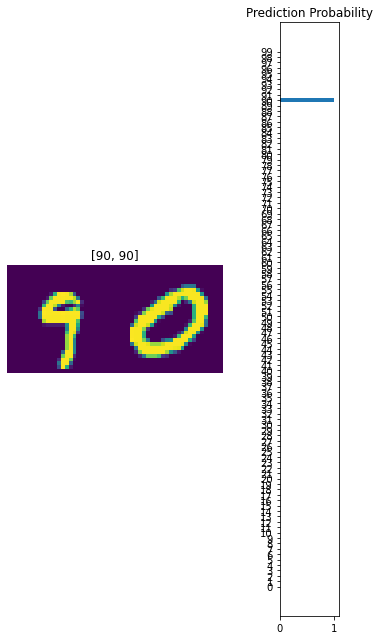

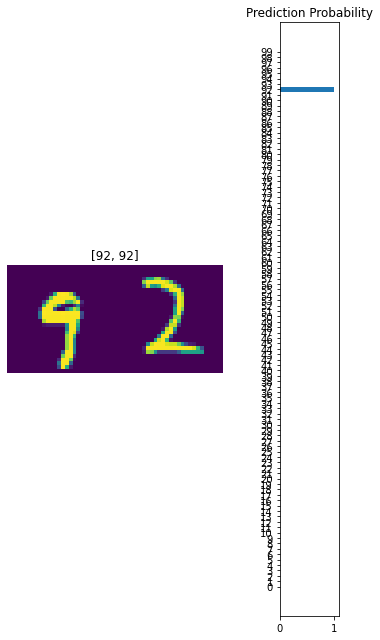

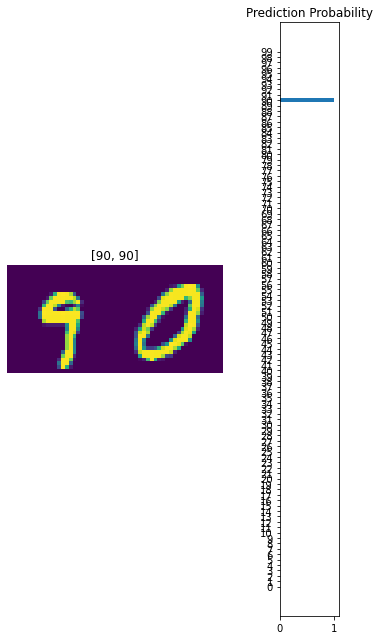

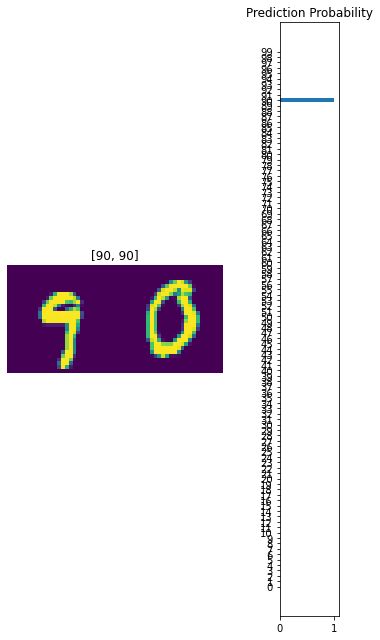

In [172]:
model_fnn.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))
img_new, lbl_new = double(image_batch, label_batch)
        
img_tensor = torch.stack(img_new)
lbl_tensor = torch.stack(lbl_new)

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_fnn(img_tensor)
for i in range(10):
    img = img_tensor[i]
    real_label = lbl_tensor[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img, pred_prob, real_label)